In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

In [2]:
import tensorflow as tf
import tf_keras as keras
import numpy as np
import matplotlib.pyplot as plt
import cv2

2024-12-17 15:50:28.066862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734429028.095869  398860 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734429028.107224  398860 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 15:50:28.137328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from IPython.display import display, ProgressBar, update_display, Math
import time

In [4]:
import pathlib
import zipfile

In [5]:
SEG_TRAIN_DATA_URL = "/home/rayat69/Downloads/ISIC-images.zip"

seg_train_download_dir = 'datasets/skin_lesion/train'

In [5]:
with zipfile.ZipFile(SEG_TRAIN_DATA_URL) as z:
    z.extractall(seg_train_download_dir + '/images')

NameError: name 'SEG_TRAIN_DATA_URL' is not defined

In [6]:
seg_train_data_dir = pathlib.Path(seg_train_download_dir).with_suffix('')
# seg_train_data_dir = seg_train_data_dir / "Scabies Dataset"
print(seg_train_data_dir)

datasets/skin_lesion/train


In [49]:
def grabcut_generate_save(image_path: pathlib.Path, save_path: pathlib.Path) -> None:
    # Read the image
    path = pathlib.Path(image_path)
    saved_img_path = save_path / f"{os.path.basename(path)}"
    
    if os.path.isfile(saved_img_path) and os.path.exists(saved_img_path):
        return cv2.imread(saved_img_path, cv2.IMREAD_GRAYSCALE)
    
    
    image = cv2.imread(image_path)
    # print(image.shape)
    image = cv2.resize(image, (256, 256))  # Resize for consistency

    # Create an initial mask
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Define a rectangle for the region of interest
    rect = (10, 10, image.shape[1] - 20, image.shape[0] - 20)  # Adjust as needed

    # Models for background and foreground
    bg_model = np.zeros((1, 65), dtype=np.float64)
    fg_model = np.zeros((1, 65), dtype=np.float64)

    # Apply GrabCut algorithm
    cv2.grabCut(image, mask, rect, bg_model, fg_model, 5, cv2.GC_INIT_WITH_RECT)

    # Convert the mask to binary
    binary_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8") * 255

    # Save the mask
    cv2.imwrite(save_path / f"{os.path.basename(path)}", binary_mask)
    # cv2.imshow("image", image)
    # cv2.imshow("mask", binary_mask)
    
    return binary_mask

In [ ]:
np.random.seed(333)
selected_for_removal = np.random.choice(list(seg_train_data_dir.glob('images/*.jpg')), 1000)

size = len(selected_for_removal)

progress = ProgressBar(size)
progress.display()

for image_path in selected_for_removal:
    progress.progress += 1
    try:
        os.remove(os.path.realpath(image_path))
    except FileNotFoundError:
        continue

[                                                            ] 11/1000

In [46]:
selected_for_removal = None
segmentation_train_images = None

In [54]:
images_path = seg_train_data_dir.glob('images/*.jpg')

size = len(list(images_path))

progress = ProgressBar(size)
display(f"[0/{size}]==================================[0s remaining]",
        display_id="progress_time")
progress.display()
start = time.time()

for image in seg_train_data_dir.glob('images/*.jpg'):
    grabcut_generate_save(image, seg_train_data_dir / "masks")
    progress.progress += 1
    end = time.time()
    avg_speed = end - start
    remaining = size - progress.progress
    remaining_time = remaining * avg_speed
    formated_time = time.strftime("%H:%M:%S", time.gmtime(remaining_time))
    display(f"[{progress.progress}/{size}]==================================[{formated_time} remaining]",
            display_id="progress_time", update=True,)
    start = end
    # break

'[3679/3679]==================================[00:00:00 remaining]'

[                                                            ] 0/3679

In [92]:
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128

IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

In [93]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [94]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = keras.layers.MaxPool2D(2)(f)
   p = keras.layers.Dropout(0.3)(p)

   return f, p

In [95]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = keras.layers.concatenate([x, conv_features])
   # dropout
   x = keras.layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [96]:
def build_unet(name: str = 'U-Net', input_shape: tuple[int, int, int] = IMG_SHAPE):
    # inputs
   inputs = keras.Input(shape=input_shape)

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = keras.layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = keras.Model(inputs, outputs, name=name)

   return unet_model

In [97]:
segmentation_train_images: tf.data.Dataset = keras.utils.image_dataset_from_directory(
    seg_train_data_dir / "images",
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=1337,
    shuffle=False
)

segmentation_train_masks: tf.data.Dataset = keras.utils.image_dataset_from_directory(
    seg_train_data_dir / "masks",
    label_mode=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=1337,
    shuffle=False,
    color_mode="grayscale"
)

Found 3679 files belonging to 1 classes.
Found 3679 files belonging to 1 classes.


In [98]:
rescale = keras.layers.Rescaling(1.0 / 255)
segmentation_train_images = segmentation_train_images.map(lambda x: rescale(x))

In [99]:
segmentation_ds = tf.data.Dataset.zip(
    (segmentation_train_images, segmentation_train_masks,))
segmentation_ds

<_ZipDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

In [100]:
ds_cardinality = tf.data.experimental.cardinality(segmentation_ds).numpy()

train_size = int(0.7 * ds_cardinality)
val_size = int(0.15 * ds_cardinality)
test_size = int(0.15 * ds_cardinality)

train_ds = segmentation_ds.take(train_size)
test_ds = segmentation_ds.skip(train_size)
val_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

segmentation_train_images = None
segmentation_train_masks = None
segmentation_ds = None

In [101]:
unet_1 = build_unet(name="U-Net", input_shape=IMG_SHAPE)

In [102]:
unet_1.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_115 (Conv2D)         (None, 128, 128, 64)         1792      ['input_11[0][0]']            
                                                                                                  
 conv2d_116 (Conv2D)         (None, 128, 128, 64)         36928     ['conv2d_115[0][0]']          
                                                                                                  
 max_pooling2d_27 (MaxPooli  (None, 64, 64, 64)           0         ['conv2d_116[0][0]']          
 ng2D)                                                                                        

In [103]:
unet_1.build(input_shape=(None, *IMG_SHAPE))

In [104]:
LEARNING_RATE = 0.0001

unet_1.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
               loss=keras.losses.SparseCategoricalCrossentropy(),
               metrics=["accuracy"])

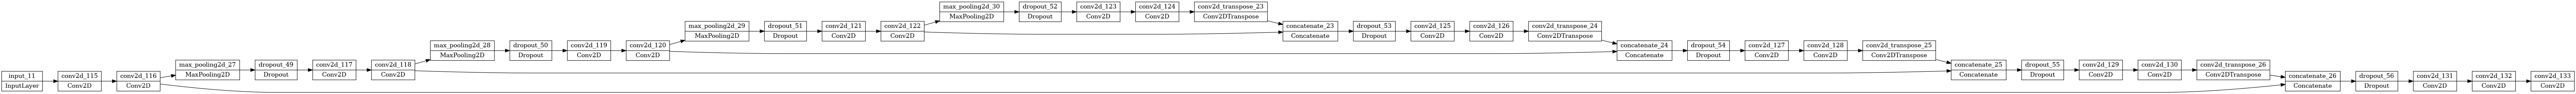

In [105]:
keras.utils.plot_model(unet_1, rankdir="LR")

In [106]:
NUM_EPOCHS = 20

history_1 = unet_1.fit(train_ds,
                       epochs=NUM_EPOCHS,
                       validation_data=val_ds,)

Epoch 1/20


E0000 00:00:1734430017.252864  398860 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout_49/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-17 16:07:00.074228: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:359] gpu_async_0 cuMemAllocAsync failed to allocate 245366784 bytes: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
 Reported by CUDA: Free memory/Total memory: 52232192/6219038720
2024-12-17 16:07:00.074781: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:364] Stats: Limit:                      4481417216
InUse:                      5949114421
MaxInUse:                   5967464501
NumAllocs:                        3087
MaxAllocSize:               1300234240
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-12-17 16:07:00.074865: E e

ResourceExhaustedError: Graph execution error:

Detected at node U-Net/conv2d_transpose_25/conv2d_transpose defined at (most recent call last):
  File "/home/rayat69/miniconda3/envs/tf/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/rayat69/miniconda3/envs/tf/lib/python3.10/runpy.py", line 86, in _run_code

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/rayat69/miniconda3/envs/tf/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/rayat69/miniconda3/envs/tf/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/rayat69/miniconda3/envs/tf/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_398860/180945262.py", line 3, in <module>

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1804, in fit

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1147, in train_step

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 588, in __call__

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/engine/functional.py", line 514, in call

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/engine/functional.py", line 671, in _run_internal_graph

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/layers/convolutional/conv2d_transpose.py", line 296, in call

  File "/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/backend.py", line 6270, in conv2d_transpose

OOM when allocating tensor with shape[32,65,65,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator gpu_async_0
	 [[{{node U-Net/conv2d_transpose_25/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_35955]

In [49]:
unet_1.save("models/skin_lesion_segmentation_unet_v1")

INFO:tensorflow:Assets written to: models/skin_lesion_segmentation_unet_v1/assets


INFO:tensorflow:Assets written to: models/skin_lesion_segmentation_unet_v1/assets


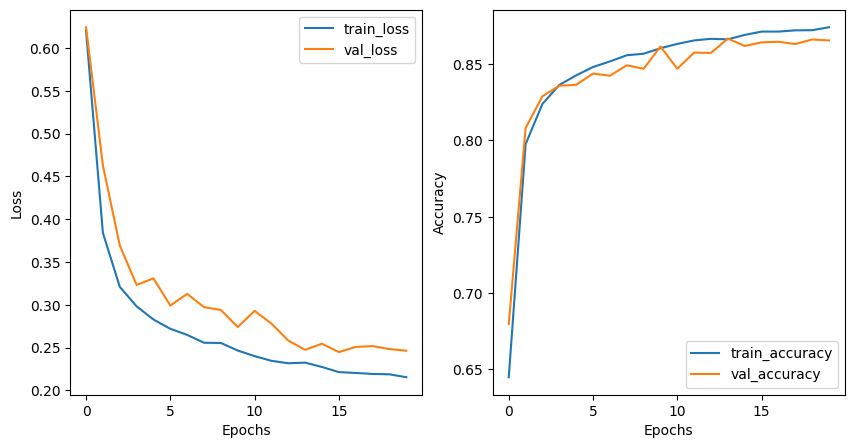

In [50]:
# plot the model results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_1.history["loss"], label="train_loss")
plt.plot(history_1.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_1.history["accuracy"], label="train_accuracy")
plt.plot(history_1.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

2/2 [==============================] - 0s 73ms/step


2024-12-16 16:14:26.537688: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


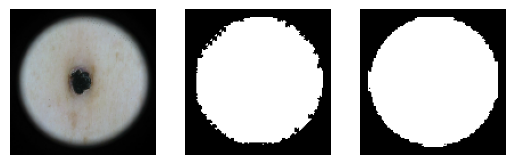

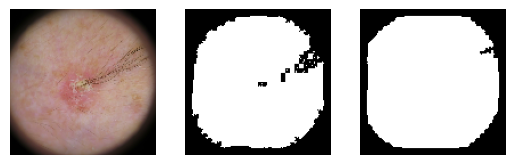

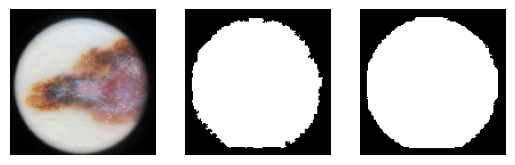

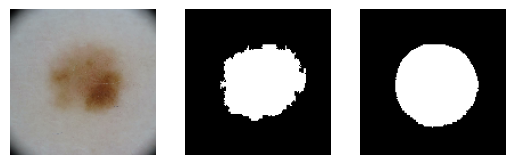

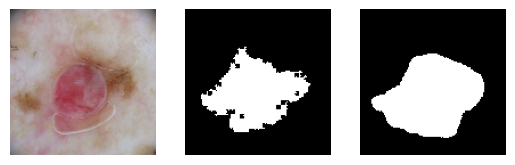

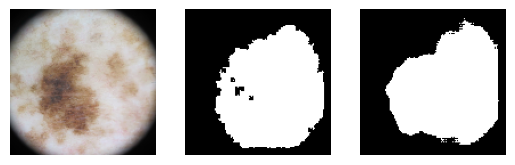

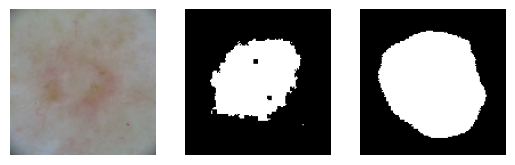

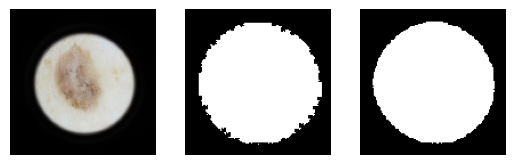

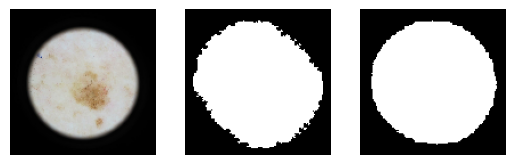

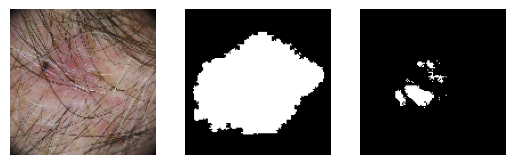

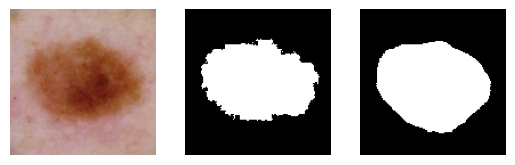

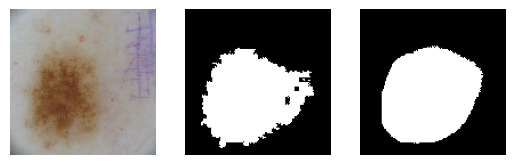

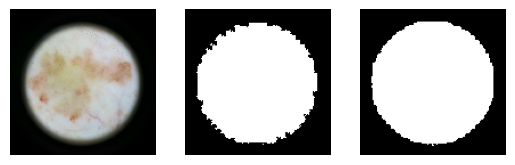

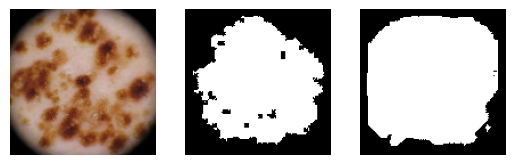

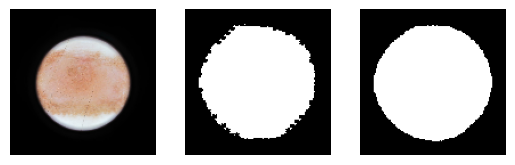

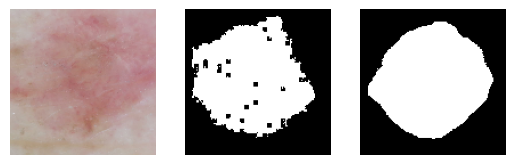

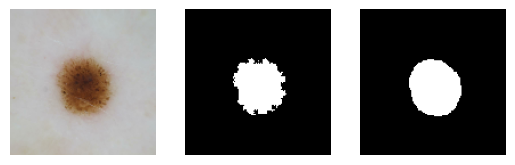

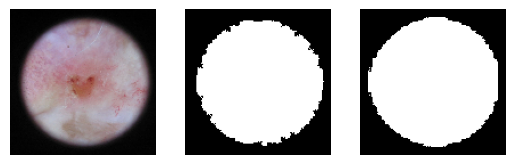

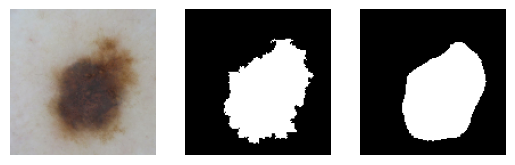

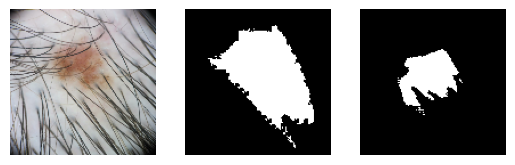

In [56]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask

for image_batch, mask_batch in test_ds.take(1):
    pred_mask = unet_1.predict(image_batch)
    for i in range(20):
        plt.subplot(1, 3, 1)
        plt.imshow((image_batch[i].numpy() * 255).astype("uint8"))
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(tf.squeeze(mask_batch[i]).numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        mask = create_mask(pred_mask[i])
        plt.imshow(tf.squeeze(mask).numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
        plt.show()

1/1 [==============================] - 0s 25ms/step


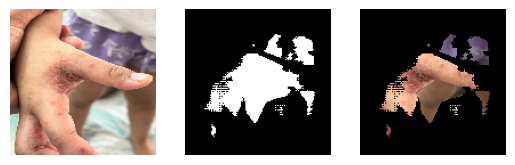

In [64]:
image_1 = keras.utils.load_img("datasets/Scabies Dataset/Scabies Images /Normal Scabies/547303cf-7ef3-4c4a-b237-f03918fab175.jpg")
image_1 = keras.utils.img_to_array(image_1)
image_1 = tf.image.resize(image_1, (IMG_HEIGHT, IMG_WIDTH))

pred = unet_1.predict(tf.expand_dims(image_1, axis=0))

mask = create_mask(pred[0])

plt.subplot(1, 3, 1)
img = image_1.numpy().astype("uint8")
plt.imshow(img)
plt.axis("off")
plt.subplot(1, 3, 2)
mask = tf.squeeze(mask).numpy().astype("uint8")
plt.imshow(mask, cmap="gray")
plt.axis("off")
expanded_mask = np.stack([mask] * 3, axis=-1)
sliced_image = expanded_mask * img
plt.subplot(1, 3, 3)
plt.imshow(sliced_image.astype("uint8"))
plt.axis("off")
plt.show()
